In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math

In [2]:
class Model:
    def __init__(self, V, I, n, m, h, t):
        self.V = V
        self.I = I
        self.n = n
        self.m = m
        self.h = h
        self.t = t

In [3]:
from numpy import exp

def solve_model(I_inj, dt, time):
    # Hodgkin-Huxley Model constants
    alpha_n = lambda V: 0.01 * (V + 55) / (1 - exp(-0.1 * (V + 55)))
    betta_n = lambda V: 0.125 * exp(-0.0125 * (V + 65))

    alpha_m = lambda V: 0.1 * (V + 40) / (1 - exp(-0.1 * (V + 40)))
    betta_m = lambda V: 4 * exp(-0.0556 * (V + 65))

    alpha_h = lambda V: 0.07 * exp(-0.05 * (V + 65))
    betta_h = lambda V: 1 / (1 + exp(-0.1 * (V + 35)))

    g_L_max = 0.003     # mS/mm^2
    g_K_max = 0.36      # mS/mm^2
    g_Na_max = 1.2      # mS/mm^2
    E_L = -54.387       # mV
    E_K = -77           # mV
    E_Na = 50           # mV
    сm = 0.01

    # Init
    t_arr  =  []
    I_arr  =  [] # this one is just to plog a graph in the same way as everything else
    Vm_arr = []
    n_arr  =  []
    m_arr  =  []
    h_arr  =  []

    # base values (approximate from pictures from the book...)
    Vm = -67
    m  = 0.05
    h  = 0.6
    n  = 0.3
    t  = 0
    
    N_iter = int(time / dt)

    for i in range(N_iter):
        t_arr.append(t)
        I_arr.append(I_inj(t))
        Vm_arr.append(Vm)
        n_arr.append(n)
        m_arr.append(m)
        h_arr.append(h)

        g_K  = g_K_max * (n ** 4)
        g_Na = g_Na_max * (m ** 3) * h
        g_L  = g_L_max # constant leakage
        gm  = g_K + g_Na + g_L

        tau_v = сm / gm
        # solving using math appendix from page 207 (eq. 5.48, 5.49, 5.50)
        Vm_inf = (I_inj(t) + g_K * E_K + g_Na * E_Na + g_L * E_L) / gm
        Vm = Vm_inf + (Vm - Vm_inf) * exp(-dt/tau_v)

        an, bn = alpha_n(Vm), betta_n(Vm)
        am, bm = alpha_m(Vm), betta_m(Vm)
        ah, bh = alpha_h(Vm), betta_h(Vm)

        tau_n = 1/(an + bn)
        tau_m = 1/(am + bm)
        tau_h = 1/(ah + bh)

        n_inf = an * tau_n
        m_inf = am * tau_m
        h_inf = ah * tau_h

        # same appendix (eq. 5.52)
        n = n_inf + (n - n_inf) * exp(-dt/tau_n)
        m = m_inf + (m - m_inf) * exp(-dt/tau_m)
        h = h_inf + (h - h_inf) * exp(-dt/tau_h)

        t += dt

    return Model(Vm_arr, I_arr, n_arr, m_arr, h_arr, t_arr)

In [4]:
def plot_model(model):
    V = model.V
    I = model.I
    n = model.n
    m = model.m
    h = model.h
    t = model.t
    
    
    # first, simply plot time series of all variables.
    f, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    axs[0][0].set_title("V(t)")
    axs[0][0].plot(t, V)

    axs[0][1].set_title("I(t)")
    axs[0][1].plot(t, I)

    axs[0][2].set_title("n(t)")
    axs[0][2].plot(t, n)

    axs[1][0].set_title("m(t)")
    axs[1][0].plot(t, m)

    axs[1][1].set_title("h(t)")
    axs[1][1].plot(t, h)
    
    plt.show()

# Part 1

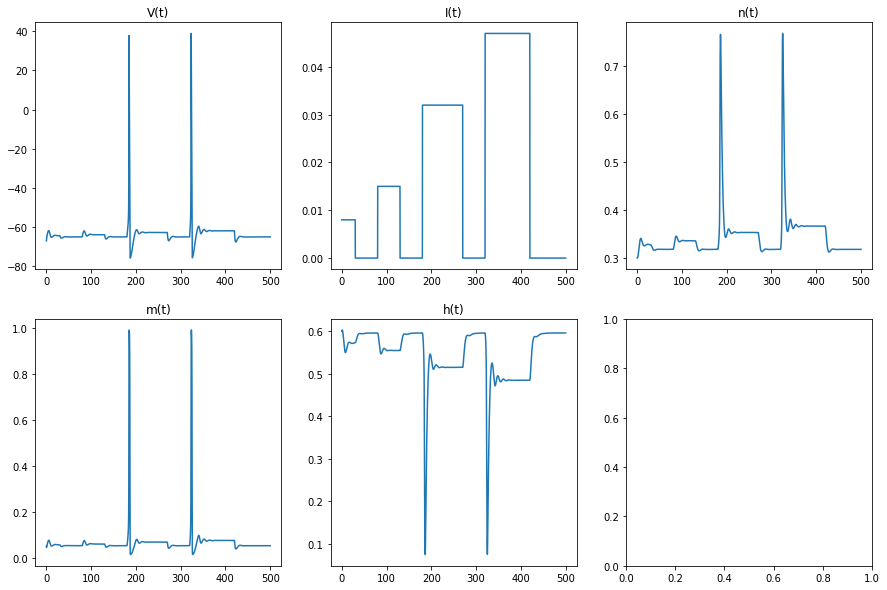

In [5]:
def I_inj_1(t):
    pause = 50
    intervals = [30, 50, 90, 100]
    currents = [8, 15, 32, 47]
    
    cur_t = 0
    for i in range(len(intervals)):
        cur_t += intervals[i]
        if t <= cur_t:
            return currents[i] / 1000 # currents should be in uA
        cur_t += pause
        if t <= cur_t:
            return 0
    
    return 0

model_1 = solve_model(I_inj_1, 0.01, 500)
plot_model(model_1)

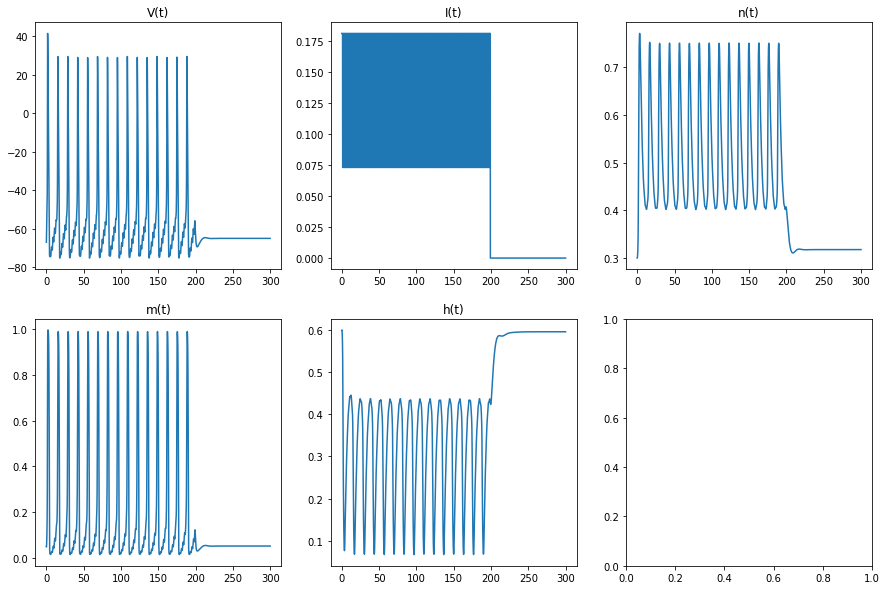

In [7]:
def I_inj_2(t):
    val1 = 73
    val2 = 181
    
    for i in range(200):
        if t < i:
            return val1 / 1000
        val1, val2 = val2, val1
    
    return 0

model_2 = solve_model(I_inj_2, 0.01, 300)
plot_model(model_2)

# Part 2

In [8]:
def plot_phase_space(model, total_time, intervals):
    f, axs = plt.subplots(len(intervals), 3, figsize=(15, 10))

    f.subplots_adjust(top=2.5)
    
    V = model.V
    n = model.n
    m = model.m
    h = model.h

    interval_start = 0
    interval_end = 0
    for i in range(len(intervals)):
        interval_end = int((intervals[i] / total_time) * len(V))
        
        s = interval_start
        e = interval_end
        
        axs[i][0].set_title("(V(t), n(t))")
        axs[i][0].plot(V[s:e], n[s:e])

        axs[i][1].set_title("(V(t), m(t))")
        axs[i][1].plot(V[s:e], m[s:e])

        axs[i][2].set_title("(V(t), h(t))")
        axs[i][2].plot(V[s:e], h[s:e])
        
        interval_start = interval_end

    plt.show()

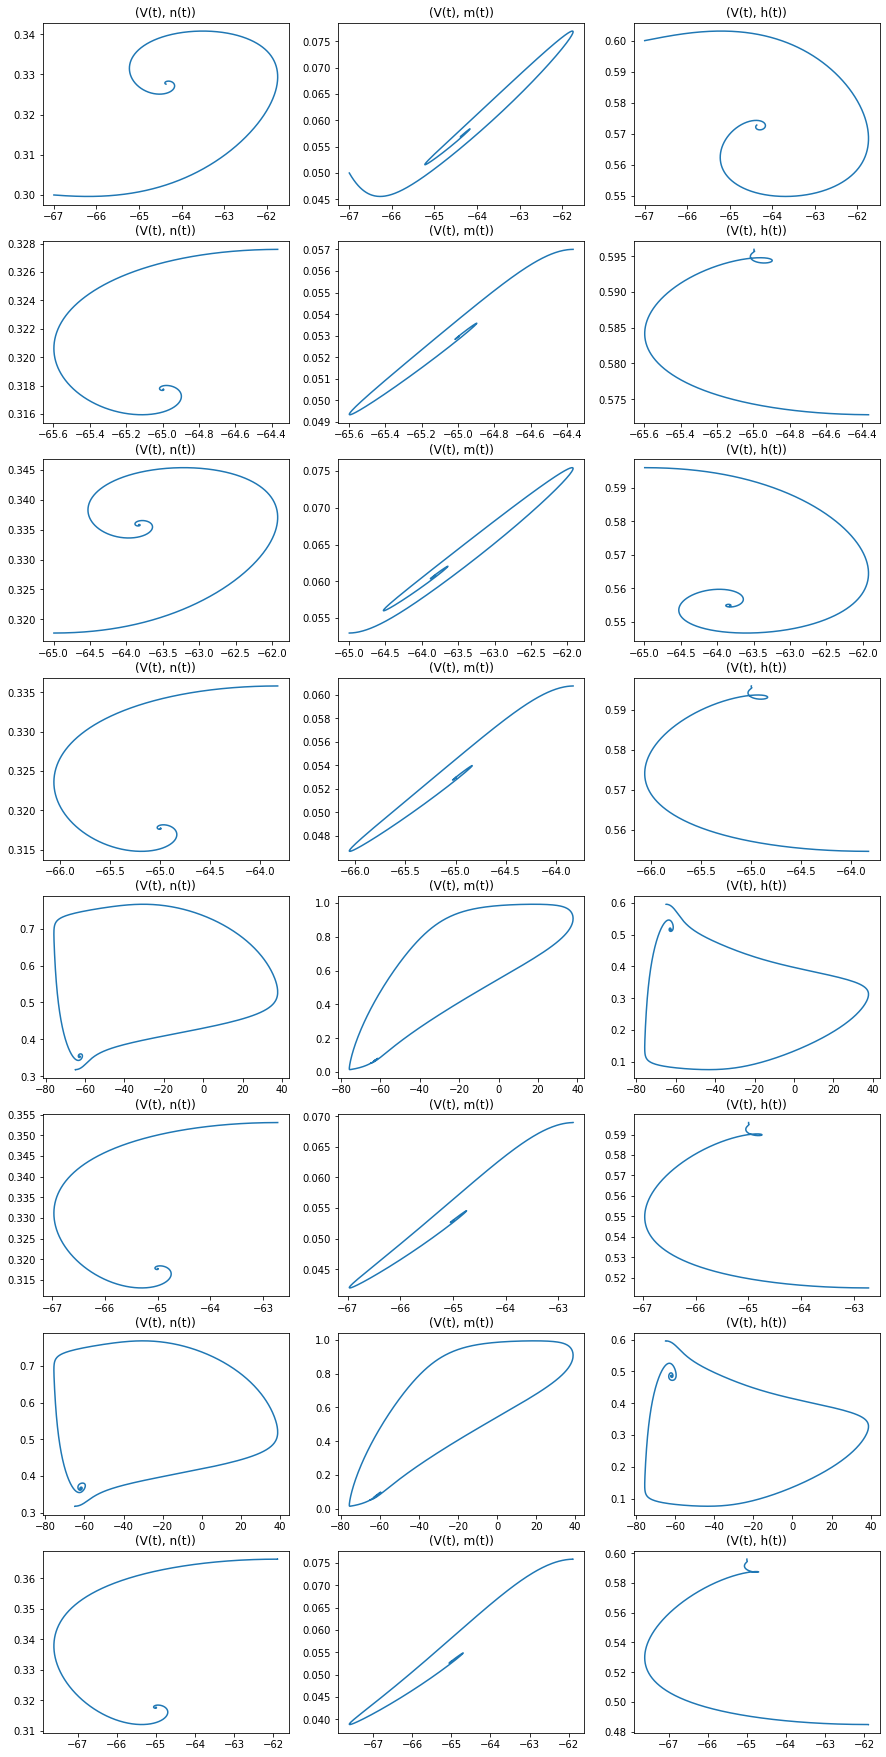

In [9]:
plot_phase_space(model_1, 500, [30, 80, 130, 180, 270, 320, 420, 500])